### Imports i carregar model + variables bàsiques globals

In [2]:
from baseline.model_autoencoder import Autoencoder
from utils import ImagesDataset
import torch
import os
import pandas as pd
import cv2
import numpy as np
from sklearn.metrics import roc_curve, auc, recall_score, accuracy_score, confusion_matrix, precision_score, f1_score
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from config import *
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import random

ModuleNotFoundError: No module named 'baseline'

In [2]:
model = Autoencoder()
model.load_state_dict(torch.load(SAVED_MODEL, map_location = torch.device('cpu')))

metadata = pd.read_csv(METADATA_FILE)
window_metadata = pd.read_csv(WINDOW_METADATA_FILE)

directories_an = [dir.path for dir in os.scandir(ANNOTATED_PATCHES_DIR) if dir.is_dir()]
directories_cr = [dir.path for dir in os.scandir(CROPPED_PATCHES_DIR) if dir.is_dir()]

### Definim funcions i altres que farem servir més endavant

In [3]:
transform = transforms.Compose([
    transforms.Resize((64,64), antialias=True),
    transforms.Normalize(mean=[0.5], std=[0.5])])

transform_un = transforms.Compose([
    transforms.Normalize(mean=[-0.5/0.5], std=[1/0.5])])

In [4]:
def red_pixels(img):
    img = img.permute(1, 2, 0).detach().numpy()
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_limit = 340
    upper_limit = 20
    count = ((img[:, :, 0] >= lower_limit) | (img[:, :, 0] <= upper_limit)).sum()

    return count

In [41]:
def df_predpac(directori, model_autoe, model_pred ):
    targets = []
    targets2 = []
    props = []
    r_or = []
    r_out = []
    max_pats = []
    mean_pats = []
    std_pats = []
    quantil1 = []
    quantil2 = []
    quantil3 = []
    restes = []
    eps=0.001
    n = 50


    for dir in directori:
        if metadata.loc[metadata["CODI"] == dir.split("/")[-1].split("_")[0], "DENSITAT"].values[0] == "NEGATIVA":
            target = 0
        elif metadata.loc[metadata["CODI"] == dir.split("/")[-1].split("_")[0], "DENSITAT"].values[0] == "ALTA":
            target = 1
        else:
            continue
        files = os.listdir(dir)
        random.shuffle(files)
        if len(files) == 0:
            continue
        if len(files) > n:
            files = files[:n]
        predict_patches = 0
        prop_pac = []
        resta = []
        for file in files:
            if window_metadata.loc[window_metadata["ID"] == str(dir.split("/")[-1])+"."+file[:-4], "Presence"].values == -1:
                targets2.append(0)
            elif window_metadata.loc[window_metadata["ID"] == str(dir.split("/")[-1])+"."+file[:-4], "Presence"].values == 1:
                targets2.append(1)
            else:
                continue
                targets2.append(1)
            img = read_image(os.path.join(dir, file))[:-1,:,:]
            img = img.to(torch.float32)
            img = img/255
            img = transform(img)
            model_autoe.eval()
            img_processed = model_autoe(img, "autoencoder")
            red_pixels_original = red_pixels(transform_un(img))
            red_pixels_output = red_pixels(transform_un(img_processed))
            test = pd.DataFrame({"Red_Original": [red_pixels_original], "Red_Output": [red_pixels_output]})
            pred = model_pred.predict_proba(test)
            r_or.append(red_pixels_original)
            r_out.append(red_pixels_output)
            if pred[:,1] >= 0.5:
                prop_pac.append(1)
                predict_patches += 1
            else:
                prop_pac.append(0)
            resta.append(abs(-red_pixels_output+red_pixels_original))
        if len(prop_pac) != 0:
            prop_pac = sorted(prop_pac)
            max_pat = max(prop_pac)   
            mean_pat = sum(prop_pac)/len(prop_pac)  
            std_pat = np.std(prop_pac)
            quantil1.append(prop_pac[int(len(prop_pac)/10)*7]) 
            quantil2.append(prop_pac[int(len(prop_pac)/10)*8]) 
            quantil3.append(prop_pac[int(len(prop_pac)/10)*9])
            restes.append(max(resta))
            prop = predict_patches/len(files)

            targets.append(target)
            props.append(prop)
            max_pats.append(max_pat)
            mean_pats.append(mean_pat)
            std_pats.append(std_pat)
            
    return pd.DataFrame({'max': max_pats, 'mean': mean_pats, 'std': std_pats, 'prop': props, 'q1': quantil1, 'q2': quantil2, 'q3': quantil3, 'resta': restes, 'target': targets}), pd.DataFrame({"Target": targets2, "RedOR": r_or, "RedOUT": r_out})


### Llegim dades d'Annotated: obtenim els valors de vermell en la imatge original i la de la sortida de l'autoencoder, així com el target. Tot això per crear un dataframe que utilitzem per entrenar un xgboost que farà la predicció dels patches.

In [6]:
target_patch = []
ror_train = []
rout_train = []

for dir in directories_an:
    files = os.listdir(dir)
    if len(files) == 0:
        continue
    for file in files:
        if window_metadata.loc[window_metadata["ID"] == str(dir.split("/")[-1])+"."+file[:-4], "Presence"].values == -1:
            target_patch.append(0)
        else:
            target_patch.append(1)
        img = read_image(os.path.join(dir, file))[:-1,:,:]
        img = img.to(torch.float32)
        img = img/255
        img = transform(img)
        model.eval()
        img_processed = model(img, "autoencoder")
        red_pixels_original = red_pixels(transform_un(img))
        red_pixels_output = red_pixels(transform_un(img_processed))
        ror_train.append(red_pixels_original)
        rout_train.append(red_pixels_output)

/tmp/ipykernel_3528988/2807909155.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if window_metadata.loc[window_metadata["ID"] == str(dir.split("/")[-1])+"."+file[:-4], "Presence"].values == -1:


In [64]:
df_train = pd.DataFrame({"Red_Original": ror_train, "Red_Output": rout_train, "Target": target_patch})
X_train, y_train = df_train.drop(columns=['Target']), df_train['Target']
X, y = df_train.drop(columns=['Target']), df_train['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle = True, random_state= 42)

In [72]:
gb_classifier = GradientBoostingClassifier(
    n_estimators=100,           # Number of boosting rounds (trees to build)
    learning_rate=0.1,          # Step size shrinkage to prevent overfitting
    max_depth=3,                # Maximum depth of a tree
    random_state=42,             # Seed for reproducibility
)

### Fem cross validation amb annotated per veure com va el model

In [10]:
n_scores = cross_val_score(gb_classifier, df_train.drop(columns=['Target']), df_train['Target'], scoring='roc_auc', cv=5, n_jobs=-1, error_score='raise')

In [11]:
#ROC AUC mitjana crossval 5
np.mean(n_scores)

0.9163500602083717

In [12]:
n_scores = cross_val_score(gb_classifier, df_train.drop(columns=['Target']), df_train['Target'], scoring='recall', cv=5, n_jobs=-1, error_score='raise')

In [13]:
np.mean(n_scores)

0.7395390070921986

### Entrenem el model amb tots els patches d'annotated

In [73]:
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [76]:
pred = gb_classifier.predict_proba(X_test)

In [82]:
predicted_labels2 = [0 if p < 0.4 else 1 for p in pred[:,1]]

# Calculate the confusion matrix
confusion_matrix2 = confusion_matrix(y_test, predicted_labels2)

# Print the confusion matrix
print("Confusion matrix patches:")
print(confusion_matrix2)

recall_score(y_test, predicted_labels2), accuracy_score(y_test, predicted_labels2), precision_score(y_test, predicted_labels2), f1_score(y_test, predicted_labels2)

Confusion matrix patches:
[[212   9]
 [  8  37]]


(0.8222222222222222,
 0.9360902255639098,
 0.8043478260869565,
 0.8131868131868132)

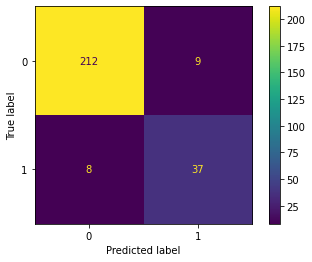

In [83]:
from utils import *
plot_confusion_matrix(y_test, predicted_labels2, '/fhome/mapsiv01/PSIV3_malaltia/autoencoder/plots', 'CM_gb_pat')

### Ara enlloc dels patches d'annotaded, crearem un df per als pacients del mateix directori. Aquest dataframe conté les columnes següents: 'max': max_pats, 'mean': mean_pats, 'std': std_pats, 'prop': props, 'q1': quantil1, 'q2': quantil2, 'q3': quantil3, 'resta': restes, 'target': targets

In [15]:
df_train2, final_results = df_predpac(directories_an, model, gb_classifier)

### Creem un altre xgboost i fem cv pels pacients d'annotated x veure com va el model, ho fem amb el dataset prèviament esmentat.

In [16]:
gb_classifier2 = GradientBoostingClassifier(
    n_estimators=100,           # Number of boosting rounds (trees to build)
    learning_rate=0.1,          # Step size shrinkage to prevent overfitting
    max_depth=3,                # Maximum depth of a tree
    random_state=42,             # Seed for reproducibility
)

In [17]:
n_scores2 = cross_val_score(gb_classifier2, df_train2.drop(columns=['target']), df_train2['target'], scoring='recall', cv=5, n_jobs=-1, error_score='raise')

In [18]:
np.mean(n_scores2)

0.7527272727272727

In [19]:
gb_classifier2.fit(df_train2.drop(columns=['target']), df_train2['target'])

GradientBoostingClassifier(random_state=42)

### Creem el dataset de test, és a dir el que conté les mateixes dades que l'anterior però pels pacients que volem predir. En aquest cas els de cropped (xo agafem 20 patches random x pacient només xq sinó és infinit)

In [42]:
df_test, final_results2 = df_predpac(directories_cr, model, gb_classifier)

/tmp/ipykernel_3528988/2385548458.py:35: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if window_metadata.loc[window_metadata["ID"] == str(dir.split("/")[-1])+"."+file[:-4], "Presence"].values == -1:
/tmp/ipykernel_3528988/2385548458.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif window_metadata.loc[window_metadata["ID"] == str(dir.split("/")[-1])+"."+file[:-4], "Presence"].values == 1:


In [58]:
def read_img(file, dir):
    img = read_image(os.path.join(dir, file))[:-1,:,:]
    img = img.to(torch.float32)
    img = img/255
    img = transform(img)
    return img

props = []
targets = []
targets2 = []
r_or = []
r_out = []
eps = 0.0001
n = 20

for dir in directories_cr:
    if metadata.loc[metadata["CODI"] == dir.split("/")[-1].split("_")[0], "DENSITAT"].values[0] == "BAIXA":
        continue
        target = 1
    if metadata.loc[metadata["CODI"] == dir.split("/")[-1].split("_")[0], "DENSITAT"].values[0] == "NEGATIVA":
        target = 0
    else:
        target = 1

    files = os.listdir(dir)
    if len(files) > n:
            files = files[:n]

    predict_patches = 0
    patches_seen = 0

    for file in files:
        patches_seen += 1
        img = read_img(file, dir)
        model.eval()
        img_processed = model(img, "autoencoder")
        red_pixels_original = red_pixels(transform_un(img))
        red_pixels_output = red_pixels(transform_un(img_processed))
        r_or.append(red_pixels_original)
        r_out.append(red_pixels_output)

        if (red_pixels_original+eps)/(red_pixels_output+eps) > 1.0:
                predict_patches += 1
    
    if patches_seen != 0:
        prop = predict_patches/patches_seen
        
        targets.append(target)
        props.append(prop)

/tmp/ipykernel_3528988/296790831.py:33: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if window_metadata.loc[window_metadata["ID"] == str(dir.split("/")[-1])+"."+file[:-4], "Presence"].values == 0:
/tmp/ipykernel_3528988/296790831.py:35: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif window_metadata.loc[window_metadata["ID"] == str(dir.split("/")[-1])+"."+file[:-4], "Presence"].values == -1:
/tmp/ipykernel_3528988/296790831.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif window_metadata.loc[window_metadata["ID"] == str(dir.split("/")[-1])+"."+file[:-4

In [60]:
final_results2 = pd.DataFrame({"Target": targets2, "Red_Original": r_or, "Red_Output": r_out})

ValueError: arrays must all be same length

In [63]:
len(r_or), len(r_out), len(targets2)

(3780, 3780, 0)

In [ ]:
pred = gb_classifier.predict_proba(final_results2.drop(columns=['Target']))

In [ ]:
predicted_labels2 = [0 if p < 0.5 else 1 for p in pred[:,1]]

# Calculate the confusion matrix
confusion_matrix2 = confusion_matrix(final_results2['Target'], predicted_labels2)

# Print the confusion matrix
print("Confusion matrix patches:")
print(confusion_matrix2)

recall_score(final_results2['Target'], predicted_labels2), accuracy_score(final_results2['Target'], predicted_labels2)

Confusion matrix patches:
[[   0    0]
 [3245  535]]


(0.14153439153439154, 0.14153439153439154)

### Fem predict proba x saber la prob de cada pacient de ser 1 o 0, és a dir, de tenir h. pylori (o cm s digui) o no

In [21]:
y_pred = gb_classifier2.predict_proba(df_test.drop(columns=['target']))

In [25]:
predicted_labels2 = [0 if p < 0.5 else 1 for p in y_pred[:,1]]

# Calculate the confusion matrix
confusion_matrix2 = confusion_matrix(df_test['target'], predicted_labels2)

# Print the confusion matrix
print("Confusion matrix patches:")
print(confusion_matrix2)

recall_score(df_test['target'], predicted_labels2), accuracy_score(df_test['target'], predicted_labels2)

Confusion matrix patches:
[[108   9]
 [ 11  61]]


(0.8472222222222222, 0.8941798941798942)

In [26]:
from utils import * 

In [ ]:
plot_confusion_matrix(df_test['target'], predicted_labels2, '/fhome/mapsiv01/PSIV3_malaltia/autoencoder/plots', 'CM_xgb_pat')

### Útilitzem threshold 0.5 x decidir la classe donades les prob retornades x l'xgboost

# Això només és una prova fent servir únicament la resta xq mirant aquest dataset sembla bastant determinant

In [24]:
df_test

,max,mean,std,prop,q1,q2,q3,resta,target
0,0,0.00,0.000000,0.00,0,0,0,0,0
1,0,0.00,0.000000,0.00,0,0,0,9,0
2,1,0.20,0.400000,0.20,0,1,1,14,1
3,1,0.10,0.300000,0.10,0,0,1,19,1
4,1,0.05,0.217945,0.05,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...
184,1,0.75,0.433013,0.75,1,1,1,230,1
185,0,0.00,0.000000,0.00,0,0,0,0,0
186,1,0.45,0.497494,0.45,1,1,1,267,1
187,0,0.00,0.000000,0.00,0,0,0,9,0


In [25]:
def plot_auc(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve patches (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f"{PLOT_LOSS_DIR}ROCcurve2.png")

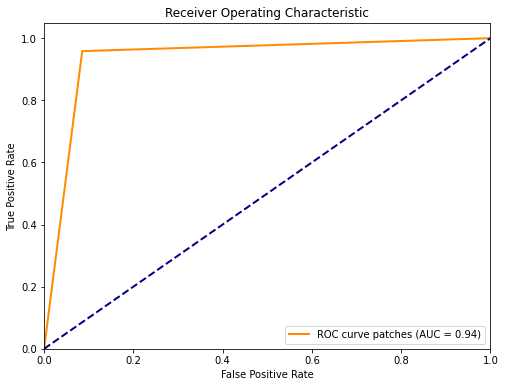

In [26]:
fpr, tpr, thresholds = roc_curve(df_test['target'], df_test['q3'])
roc_auc = auc(fpr, tpr)
plot_auc(fpr, tpr, roc_auc)

In [27]:
J2 = tpr - fpr
best_threshold = thresholds[np.argmax(J2)]
print(best_threshold)

1


In [28]:

predicted_labels2 = [1 if r >= best_threshold else 0 for r in df_test['q3']]

# Calculate the confusion matrix
confusion_matrix2 = confusion_matrix(df_test['target'], predicted_labels2)

# Print the confusion matrix
print("Confusion matrix patches:")
print(confusion_matrix2)

recall_score(df_test['target'], predicted_labels2), accuracy_score(df_test['target'], predicted_labels2)

Confusion matrix patches:
[[107  10]
 [  3  69]]


(0.9583333333333334, 0.9312169312169312)

# Aquí acaba la prova ^

In [29]:
df_test.corr()

,max,mean,std,prop,q1,q2,q3,resta,target
max,1.000000,0.648629,0.924479,0.648629,0.478516,0.606890,0.782666,0.397537,0.680772
mean,0.648629,1.000000,0.827243,1.000000,0.875223,0.857897,0.767755,0.708528,0.776789
std,0.924479,0.827243,1.000000,0.827243,0.703244,0.834680,0.913799,0.519006,0.847548
prop,0.648629,1.000000,0.827243,1.000000,0.875223,0.857897,0.767755,0.708528,0.776789
q1,0.478516,0.875223,0.703244,0.875223,1.000000,0.788472,0.611392,0.612781,0.660486
q2,0.606890,0.857897,0.834680,0.857897,0.788472,1.000000,0.775413,0.542213,0.837678
q3,0.782666,0.767755,0.913799,0.767755,0.611392,0.775413,1.000000,0.483393,0.859400
resta,0.397537,0.708528,0.519006,0.708528,0.612781,0.542213,0.483393,1.000000,0.473678
target,0.680772,0.776789,0.847548,0.776789,0.660486,0.837678,0.859400,0.473678,1.000000
